# Siamese Network using Keras

This is a more difficult version of the standard assignment:
<br>  You have more to fill in, but also more flexibility
<br>
<br>
<br>This assignment is testing a "what if" we use a siamese network as a feature extractor:
<br>1) Train a Siamese Network using 3 inputs: reference, same_class, diff_class, and
<br>2) Train a classifier built on top of the features extracted by the Siamese network
<br>   (Siamese weights are Frozen)
<br>
<br>Look for the triple apostrophes
<br>
<br>
<br>To see what you are supposed to fill in
<br>
<br>Note this is not how siamese networks are commonly used!
<br>Commonly they are used a final verification step (e.g. facial recognition)
<br>
<br>Less commonly they are used to compare against all classes, running the network
<br>many times.
<br>
<br>

Import Packages

In [1]:
import numpy as np
import seaborn as sns
import scipy.io as sio
import time
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
% matplotlib inline

from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Dropout
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, concatenate, Lambda
from tensorflow.python.keras.models import Model, model_from_json
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras import backend as K


from tensorflow.python.keras.layers.merge import Concatenate
from tensorflow.python.keras.initializers import glorot_uniform

# from tensorflow.python.keras.engine.topology import Layer
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.regularizers import l2


import random
from sklearn.metrics import confusion_matrix

C:\Users\1130135\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\1130135\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\1130135\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\1130135\AppData\Loc

Define Helper Functions

In [2]:
# Converts integer labels into one-hot vectors
def to_one_hot(labels, n_classes, p_max = 1.0):
    # Calculate the minimum probability of class based on max probability
    p_min = 0.0 if p_max == 1.0 else (1.0 - p_max)/(n_classes - 1)

    # allocate memory for one hot labels
    labels = labels.astype(np.int32)
    n_labels = labels.shape[0]
    oh_labels = np.full((n_labels, n_classes), p_min)
    # minus 1 because Matlab uses 1 based indexing
    oh_labels[np.arange(n_labels), labels-1] = p_max
    return oh_labels

def to_int_label(labels):
    int_labels = np.zeros((len(labels),))
    for i in range(len(labels)):
        int_labels[i] = np.argmax(labels[i])
    return int_labels


'''
    Custom loss function:
    Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    
'''
def contrastive_loss(y_true, y_pred):
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

"""
    Try writing another loss function like MSE or Cosine
"""
def mse_loss(stuff):
    other_stuff = stuff
    return other_stuff

# Import Data

In [3]:
TRAINING_FILE = '../training.mat'
VALIDATION_FILE = '../validation.mat'
TESTING_FILE = '../testing.mat'

In [4]:
## Data
print('Loading Training Data')
training_data = sio.loadmat(TRAINING_FILE, squeeze_me=True)
training_ims = training_data['data'].T  # .T --> transpose
training_labels = training_data['labels']

# Validation Data
MAX_VALIDATION_SAMPLES = int(2000) # at most 10,000 in this dataset

print('Loading Validation Data')
validation_data = sio.loadmat(VALIDATION_FILE, squeeze_me=True)
validation_ims = validation_data['data'].T
validation_labels = validation_data['labels']
# Limit our Validation data since we don't really need 10k of them
validation_ims = validation_ims[:MAX_VALIDATION_SAMPLES]
validation_labels = validation_labels[:MAX_VALIDATION_SAMPLES]


# Testing data
print('Loading Testing Data')
testing_data = sio.loadmat(TESTING_FILE, squeeze_me=True)
testing_ims = testing_data['data'].T
testing_labels = testing_data['labels']

Loading Training Data
Loading Validation Data
Loading Testing Data


Data Attributes

In [5]:
## Data attributes (look them up, but are effectively constant)
# These could be hard coded, but extracting them from the data anyway
im_rows = im_cols = int(np.sqrt(testing_ims.shape[1]))
print('Number of Rows/Cols:', im_rows)
num_classes = int(np.amax(testing_labels))
print('Number of Classes:', num_classes)

Number of Rows/Cols: 28
Number of Classes: 10


Data Pre-processing

In [6]:
## Data preprocessing
print('Reformating labels to one-hot')
# training_labels   = to_one_hot(training_labels, num_classes)
# validation_labels = to_one_hot(validation_labels, num_classes)
# testing_labels    = to_one_hot(testing_labels, num_classes)
y_train = training_labels - 1
y_val = validation_labels - 1
y_test = testing_labels - 1

print('Reshaping data from [img, pixels] to [img, row, col, channel]')
training_ims   = np.reshape(training_ims, (-1, im_rows, im_cols))
validation_ims = np.reshape(validation_ims, (-1, im_rows, im_cols))
testing_ims    = np.reshape(testing_ims, (-1, im_rows, im_cols))

X_train = training_ims.astype('float32')
X_val = validation_ims.astype('float32')
X_test = testing_ims.astype('float32')
X_train /= 255
X_val /= 255
X_test /= 255

print("Train data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

input_shape = X_train.shape[1:]
print('Input shape:',input_shape)

Reformating labels to one-hot
Reshaping data from [img, pixels] to [img, row, col, channel]
Train data shape: (50000, 28, 28)
Validation data shape: (2000, 28, 28)
Test data shape: (10000, 28, 28)
Input shape: (28, 28)


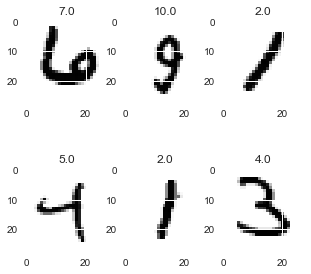

In [7]:
# Visualize Training Data

fig , axs = plt.subplots(2,3 ,figsize = (5,5))

axs[0][0].imshow(np.reshape(training_ims[0],(training_ims.shape[1],training_ims.shape[1])))
axs[0][0].set_title(training_labels[0])

axs[0][1].imshow(np.reshape(training_ims[1],(training_ims.shape[1],training_ims.shape[1])))
axs[0][1].set_title(training_labels[1])

axs[0][2].imshow(np.reshape(training_ims[2],(training_ims.shape[1],training_ims.shape[1])))
axs[0][2].set_title(training_labels[2])

axs[1][0].imshow(np.reshape(training_ims[3],(training_ims.shape[1],training_ims.shape[1])))
axs[1][0].set_title(training_labels[3])

axs[1][1].imshow(np.reshape(training_ims[4],(training_ims.shape[1],training_ims.shape[1])))
axs[1][1].set_title(training_labels[4])

axs[1][2].imshow(np.reshape(training_ims[5],(training_ims.shape[1],training_ims.shape[1])))
axs[1][2].set_title(training_labels[5])

plt.show()

# Create Pairs

In [8]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

# create training+test positive and negative pairs
def output_pairs(X,y):
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
    t_pairs, t_y = create_pairs(X, digit_indices)
    return t_pairs, t_y

In [9]:
train_pairs, train_y = output_pairs(X_train,y_train)
val_pairs, val_y = output_pairs(X_val,y_val)
test_pairs, test_y = output_pairs(X_test,y_test)

# Siamese Network

<font size="4">Structure: </font>
<font size="3">
<br>- Two inputs fed to two neural networks that share the same parameters (networks are identical)
<br>- Networks are trained to extract comparable features from the inputs
<br>- Outputs a similarity measure between the hidden representations of the two inputs
<br>- Parameters of the two networks and the distance measure are learned jointly to predict whether two inputs are similar
<br>- Ultimately tells us whether two inputs belong to the same class or different classes
</font>

Define Model

In [10]:
def SiameseModel(input_shape):
    
    # Define Input
    X_input  = Input(input_shape)
    
    # Flatten
    X = Flatten()(X_input)
    
    # First fully connected layer and Dropout
    X = Dense(128, activation='relu')(X)
    X = Dropout(0.1)(X)
    
    # Second fully connected layer and Dropout
    X = Dense(128, activation='relu')(X)
    X = Dropout(0.1)(X)
    
    # Third fully connected layer
    X = Dense(128, activation='relu')(X)
    
    X = Lambda(lambda  X: K.l2_normalize(X,axis=1))(X)
    X = Lambda(lambda  X: K.l2_normalize(X,axis=1))(X)
    
    return Model(X_input, X)   

In [11]:
def SiameseNet(input_shape):
    
    BaseNet = SiameseModel(input_shape)
    
    # Define the tensors for the two input images    
    X_left = Input(input_shape)
    X_right = Input(input_shape)
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = BaseNet(X_left)
    encoded_r = BaseNet(X_right)
    
    # custom layer to compute difference between the encodings, try something different ...
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    
    # Connect the inputs with the outputs
    model = Model([X_left,X_right],prediction)
    
    return model

In [12]:
model = SiameseNet((28,28))

Compile

In [13]:
def accuracy(y_true, y_pred):
    '''
        Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

model.compile(optimizer = 'adam', loss = contrastive_loss, metrics=[accuracy])

Fit

In [14]:
BATCH_SIZE = 32
N_EPOCH = 25

history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_y,
          batch_size=BATCH_SIZE,
          epochs=N_EPOCH,
          validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_y))

Train on 91260 samples, validate on 3080 samples
Epoch 1/25
91260/91260 [==============================] - 8s 92us/step - loss: 0.1561 - accuracy: 0.7873 - val_loss: 0.1373 - val_accuracy: 0.8234
Epoch 2/25
91260/91260 [==============================] - 8s 85us/step - loss: 0.1021 - accuracy: 0.8703 - val_loss: 0.0849 - val_accuracy: 0.8929
Epoch 3/25
91260/91260 [==============================] - 8s 89us/step - loss: 0.0808 - accuracy: 0.8975 - val_loss: 0.0672 - val_accuracy: 0.9120
Epoch 4/25
91260/91260 [==============================] - 8s 86us/step - loss: 0.0630 - accuracy: 0.9203 - val_loss: 0.0492 - val_accuracy: 0.9390
Epoch 5/25
91260/91260 [==============================] - 8s 88us/step - loss: 0.0509 - accuracy: 0.9374 - val_loss: 0.0431 - val_accuracy: 0.9458
Epoch 6/25
91260/91260 [==============================] - 8s 90us/step - loss: 0.0425 - accuracy: 0.9472 - val_loss: 0.0358 - val_accuracy: 0.9529
Epoch 7/25
91260/91260 [==============================] - 8s 87us/ste

Predict

In [15]:
def compute_accuracy(y_true, y_pred):
    '''
        Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [16]:
# compute final accuracy on training and test sets
y_pred_train = model.predict([train_pairs[:, 0], train_pairs[:, 1]])
train_acc = compute_accuracy(train_y, y_pred_train)

y_pred_test = model.predict([test_pairs[:, 0], test_pairs[:, 1]])
test_acc = compute_accuracy(test_y, y_pred_test)

print('Accuracy on training set: %0.2f%%' % (100 * train_acc))
print('Accuracy on test set: %0.2f%%' % (100 * test_acc))

Accuracy on training set: 98.85%
Accuracy on test set: 97.28%


# Learning Curves

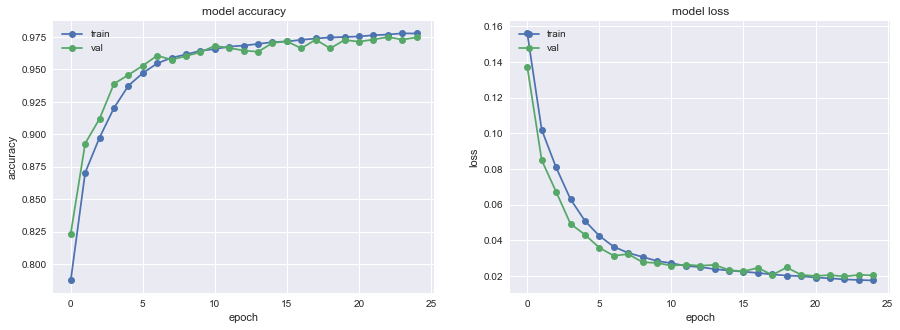

In [17]:
plt.figure(figsize = (15,5))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history.history['accuracy'],'o-')
plt.plot(history.history['val_accuracy'],'o-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history.history['loss'],'o-')
plt.plot(history.history['val_loss'],'o-')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# t-distributed Stochastic Neighbor Embedding

In [19]:
# Plot the representation learned from the siamese network
n_samples = 10000
index = np.random.choice(X_train.shape[0], size=n_samples, replace=False)
X = X_train[index]
y = y_train[index]

base_network = SiameseModel(input_shape)
embeddings = base_network.predict(X)

In [20]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,random_state=10).fit_transform(embeddings)

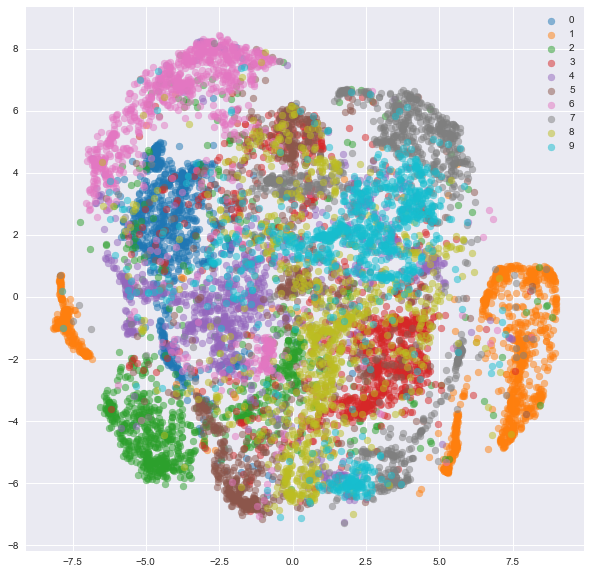

In [21]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

plt.figure(figsize=(10,10))
for i in range(10):
    inds = np.where(y==i)[0]
    plt.scatter(X_embedded[inds,0], X_embedded[inds,1], alpha=0.5, color=colors[i])
plt.legend(mnist_classes)

In [ ]:
# https://www.kaggle.com/valerasarapas/keras-siamese-network-on-mnist

# Save Model

In [ ]:
#  serialize model to JSON
model_json = m.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
m.save_weights("model.h5")
print("Saved model to disk")

# Load Model

In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Evaluate Loaded Model

In [ ]:
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(testing_ims, testing_labels, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))